# CS5950 Course Project

This project recaps and systematises work that has been done in practical sessions.  The aim of the project is to give you the experience of trying to develop a neural network classifier (or regressor), involving setting up a model, optimising the amount of regularisatio, investigating its performance, and devising a new model. 

You should do your work in this notebook, filling in the sections below. To do the work, you may re-use code from ***any of the lab-session sheets provided so far***. (In fact, you should be able to do nearly the entire project using code taken from previous lab sessions.) 

Please complete this workbook and submit it on Moodle, with all outputs (numbers and graphs) visible and included. 

The deadline for this assignment is **Friday March 29th, 23:59pm**

This project has **5%** of the marks of the course.

Please write your student number **here**: 2290    
so that I have an identifier of which worksheet I am marking, to prevent any confusion! (I have to download your notebooks before marking them, so I don't want to accidentally give credit for your notebook to somebody else...) 

## Set up dataset

You may choose any of the datasets included with Keras, or used in the course so far (including, for example, the percolation data). (It is a free country and you may use any other data you wish.)

A safe choice would be either the MNIST data or the MNIST-fashion data, which is a drop-in replacement for MNIST (same size data format, same number of classes, same number of training and test examples). 

In setting up the data, you should set up a training set and a test set. The test set should be large enough to give a reasonably accurate assessment of the error-rate (or loss) of your models: preferably at least 10,000 examples.

For the learning curve experiment (below), you will need to construct training sets of different sizes, with the largest at least 10 times the smallest. For the MNIST data, for example, your smallest training set might be 500, with sizes 500, 1000, 2000, 4000, 8000, 16000, 32000, and perhaps 60000 if you have time. (You get no extra marks for doing very long experiments.) 

## Set up model 

Set up a Keras model (you may find it helpful to keep it simple and fast to train). Train on an intermediate-sized dataset (if you are using MNIST, say 2000 or 4000). 


Plot the loss and error rate as a function of training epochs. 


###  1.  Assessment of initial model:    ***12 marks***

Ensure that your model is complex enough to *overfit* the training data: that is the loss/error-rate on the training set should be below your target loss/error-rate, and the loss/error-rate on the validation set should be higher than this (preferably higher than your target error-rate). 

In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def make_dataset(train_size, test_size, num_classes = 10):
  # input image dimensions
  img_rows, img_cols = 28, 28

  # the data, split between train and test sets
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  
  # reshape the image for training
  if K.image_data_format() == 'channels_first':
      x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
      x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
      input_shape = (1, img_rows, img_cols)
  else:
      x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
      x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
      input_shape = (img_rows, img_cols, 1)
  
  # sanity check!
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  
  # sample neccesary dataset from the original one: 60,000(train), 10,000(test)
  x_train, x_test = x_train[:train_size,:,:,:], x_train[:test_size,:,:,:]
  y_train, y_test = y_train[:train_size], y_test[:test_size]

  # normalise the dataset
  x_train /= 255
  x_test /= 255
  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_test.shape[0], 'test samples')

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  return (x_train, y_train, x_test, y_test), input_shape

In [0]:
def create_model(data, input_shape, num_classes, batch_size, epochs, dropout=0.5, is_drop_out=False):
  x_train, y_train, x_test, y_test = data
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                   activation='relu',
                   input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  
  if is_drop_out:
    model.add(Dropout(dropout))
  
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])
  
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))
  return model, history

In [0]:
# hyperparameters
batch_size = 32
epochs = 20

train_size  = 3000
test_size   = 1000
num_classes = 10

In [10]:
data, input_shape = make_dataset(train_size, test_size, num_classes)

model, history_without_dropout = create_model(data, input_shape, num_classes, batch_size, epochs, is_drop_out=False)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (3000, 28, 28, 1)
3000 train samples
1000 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### 2.  Regularisation experiment:  ***12 marks***

Now select a type of regularisation (which may be L2, L1, L12, or dropout) and train your initial model with different amounts of regularisation. 

A small amount of regularisation may improve the validation set performance of your overfitted model; too much regularisation may make performance on the validation set worse. 

Train your model multiple times, applying different amounts of regularisation, and plot a graoph showing the effect of different amounts of regularisation. 

Plot the amount of regularisation along the x axis, and the validation set performance (loss/error-rate) on the y axis.  How does regularisation affect the performance of your initial network, and what is the optimal amount? 

In [11]:
result = list()
for rate in [0.25, 0.5, 0.75]:
    data, input_shape = make_dataset(train_size, test_size, num_classes)
    model, history_with_dropout = create_model(data, input_shape, num_classes, batch_size, epochs, dropout=rate, is_drop_out=True)
    result.append(history_with_dropout.history['val_loss'])

x_train shape: (3000, 28, 28, 1)
3000 train samples
1000 test samples
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
x_train shape: (3000, 28, 28, 1)
3000 train samples
1000 test samples
x_train shape: (3000, 28, 28, 1)
3000 train samples
1000 test samples


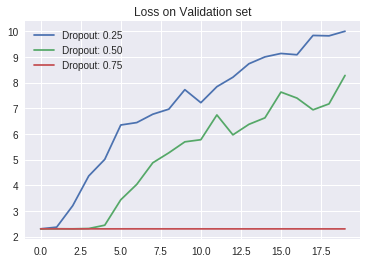

In [12]:
plt.plot(result[0], label="Dropout: 0.25")
plt.plot(result[1], label="Dropout: 0.50")
plt.plot(result[2], label="Dropout: 0.75")
plt.title("Loss on Validation set")
plt.legend()
plt.show()

### 3.  Learning curve experiment:  ***12 marks***

Now train your model (with the amount of regularisation you selected) on different amounts of training data. 

Plot the performance (loss/error-rate) of the model on the validation set against the size of the training set. 
This is typically best done on a log-log plot. 

Describe the approximate relationship between the training set size and loss / error-rate.  Does the network performance appear to improve as some power of the amount of data in the training set?  If so, by what power ? 

For example, a very good rate of improvement is for error-rate to be proportional to $\dfrac{1}{\sqrt{n}}$ where $n$ is the training set size.  For your model, the rate of improvement of validation error with training set size may not be as fast as this (or it may, who knows?)  The aim of this exercise is to find out what it actually is. 

In [13]:
logs_wo_dropout, logs_with_dropout  = dict(), dict()

for train_size, test_size in zip([2000, 4000, 8000, 16000, 32000], [500, 1000, 2000, 4000, 8000]):
  data, input_shape = make_dataset(train_size, test_size, num_classes)
  _, history_with_dropout = create_model(data, input_shape, num_classes, batch_size, epochs, dropout=0.75, is_drop_out=True)
  _, history_wo_dropout = create_model(data, input_shape, num_classes, batch_size, epochs, is_drop_out=False)
  
  logs_wo_dropout["W/O Dropout_{0}".format(train_size)] = history_wo_dropout.history['val_loss']
  logs_with_dropout["With Dropout_{0}".format(train_size)] = history_with_dropout.history['val_loss']

x_train shape: (2000, 28, 28, 1)
2000 train samples
500 test samples
x_train shape: (4000, 28, 28, 1)
4000 train samples
1000 test samples
x_train shape: (8000, 28, 28, 1)
8000 train samples
2000 test samples
x_train shape: (16000, 28, 28, 1)
16000 train samples
4000 test samples
x_train shape: (32000, 28, 28, 1)
32000 train samples
8000 test samples


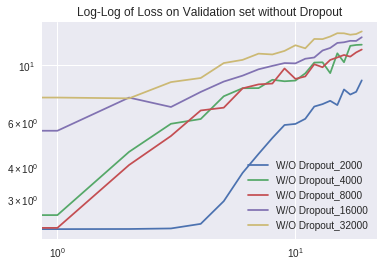

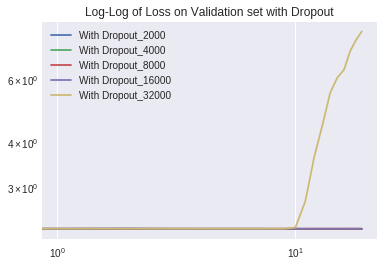

In [14]:
for key, value in logs_wo_dropout.items():
    plt.loglog(value, label=key)

plt.legend()
plt.title("Log-Log of Loss on Validation set without Dropout")
plt.show()

for key, value in logs_with_dropout.items():
    plt.loglog(value, label=key)

plt.legend()
plt.title("Log-Log of Loss on Validation set with Dropout")
plt.show()

### 4. Second model:   *** 14 marks ***

Devise what you believe to be a better neural network architecture for the problem (e.g. for MNIST you might use a fully-connected network for your initial model, and then try a convolutional net for your second model).

Repeata sections 2 (regularisation experiment), and determine whether it has better validation set performance than the first model, for an intermediate size of training set (e.g. 2000 or 4000 for the MNIST data). 

Repeat section 3. Does your model have a different learning curve from the first? Plot the learning curves for the first and second model on the same graph, to compare them. Comment: is there a more rapid reduction of error-rate with training set size for your second model?  

In [0]:
def new_create_model(data, input_shape, num_classes, batch_size, epochs):
  x_train, y_train, x_test, y_test = data
  model = Sequential()

  model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = input_shape))
  model.add(BatchNormalization())

  model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
  model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(BatchNormalization())

  model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(256, activation = "relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Dense(10, activation = "softmax"))
  
  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  model.compile(loss="categorical_crossentropy",
                optimizer=optimizer,
                metrics=["accuracy"])
  
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test))
  return model, history

In [16]:
logs_new_model = dict()

for train_size, test_size in zip([2000, 4000, 8000, 16000, 32000], [500, 1000, 2000, 4000, 8000]):
  data, input_shape = make_dataset(train_size, test_size, num_classes)
  _, history_new_model = new_create_model(data, input_shape, num_classes, batch_size, epochs)
  
  logs_new_model["size_{0}".format(train_size)] = history_new_model.history['val_loss']

x_train shape: (2000, 28, 28, 1)
2000 train samples
500 test samples
x_train shape: (4000, 28, 28, 1)
4000 train samples
1000 test samples
x_train shape: (8000, 28, 28, 1)
8000 train samples
2000 test samples
x_train shape: (16000, 28, 28, 1)
16000 train samples
4000 test samples
x_train shape: (32000, 28, 28, 1)
32000 train samples
8000 test samples


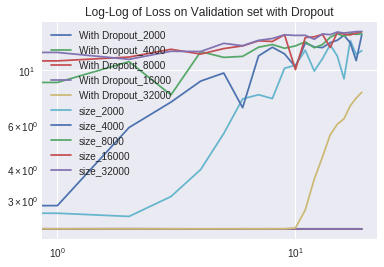

In [19]:
for key, value in logs_with_dropout.items():
    plt.loglog(value, label=key)

for key, value in logs_new_model.items():
    plt.loglog(value, label=key)

plt.legend()
plt.title("Log-Log of Loss on Validation set with Dropout")
plt.show()

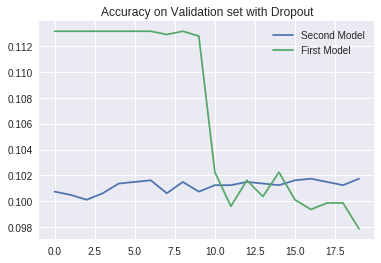

In [22]:
plt.plot(history_new_model.history["val_acc"], label="Second Model")
plt.plot(history_with_dropout.history["val_acc"], label="First Model")

plt.legend()
plt.title("Accuracy on Validation set with Dropout")
plt.show()

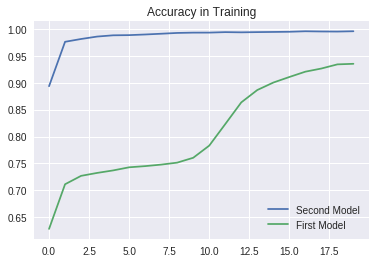

In [23]:
plt.plot(history_new_model.history["acc"], label="Second Model")
plt.plot(history_with_dropout.history["acc"], label="First Model")

plt.legend()
plt.title("Accuracy in Training")
plt.show()